In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.integrate import solve_ivp
from scipy.linalg import eigvals

In [34]:
def Kder_complex(z,Delta,Omega,K,F):
    return ((K*z +F) - (z**2)*np.conj(K*z+F))/2 - (Delta + Omega*1j)*z

def Kder_vector(z,Delta,Omega,K,F): #z is treated as a 2D vector in R^2
    x = z[0]
    y = z[1]
    zdot = Kder_complex(x+y*1j,Delta,Omega,K,F)
    xdot = np.real(zdot)
    ydot = np.imag(zdot)
    return [xdot,ydot]

def Kder_integration(t,z,Delta,Omega,K,F): #z is treated as a 2D vector in R^2
    x = z[0]
    y = z[1]
    zdot = Kder_complex(x+y*1j,Delta,Omega,K,F)
    xdot = np.real(zdot)
    ydot = np.imag(zdot)
    return [xdot,ydot]

In [36]:
def getIC(lag,Delta,Omega,K,F):
    solstb = opt.fsolve(Kder_vector,[1,-1],(Delta,Omega,K,F))
    solstb_complex = solstb[0]+1j*solstb[1]
    IC = solstb_complex*np.exp(-1j*lag*np.pi/12)
    return [IC.real,IC.imag,solstb[0],solstb[1]]

In [51]:
t_start_0 = 0
t_end_0 = 1000 #hours
t_step_0 = 1 #hours
def integrate(t_start,t_end,t_step,lag,Delta = 3.8e-3,Omega_by_delta = 1.4,K_by_delta = 10,F_by_delta = 3.5):#Put correct values
    Omega = Delta*Omega_by_delta
    K = Delta*K_by_delta
    F = Delta*F_by_delta
    ICx,ICy,solstbx,solstby = getIC(lag,Delta,Omega,K,F)
    IC = [ICx,ICy]
    def recovery(t,z,Delta,Omega,K,F):
        x = z[0]
        y = z[1]
        return (x-solstbx)**2 + (y-solstby)**2 - 0.0001
    recovery.terminal = True
    recovery.direction = -1 #only counts positive to negative crossing
    solution = solve_ivp(Kder_integration,(t_start,t_end),IC,t_eval = np.linspace(t_start,t_end,int((t_end - t_start)/t_step)),events=recovery,args=(Delta,Omega,K,F))
    return solution

In [59]:
myrangex = np.linspace(-1,1,40)
myrangey = np.linspace(-1,1,40)
x,y = np.meshgrid(myrangex,myrangey)
z = x + 1j*y
zdot = Kder_complex(z,Delta = 3.8e-3,Omega = 1.4*Delta,K = 10*Delta,F = 3.5*Delta)#Put correct values here
u = np.real(zdot)/np.abs(zdot)
v = np.imag(zdot)/np.abs(zdot)

In [60]:
solstb = opt.fsolve(Kder_vector,[1,-1],(Delta,Omega,K,F))
solunstb = opt.fsolve(Kder_vector,[0,0],(Delta,Omega,K,F))
solsad = opt.fsolve(Kder_vector,[-1,0],(Delta,Omega,K,F))

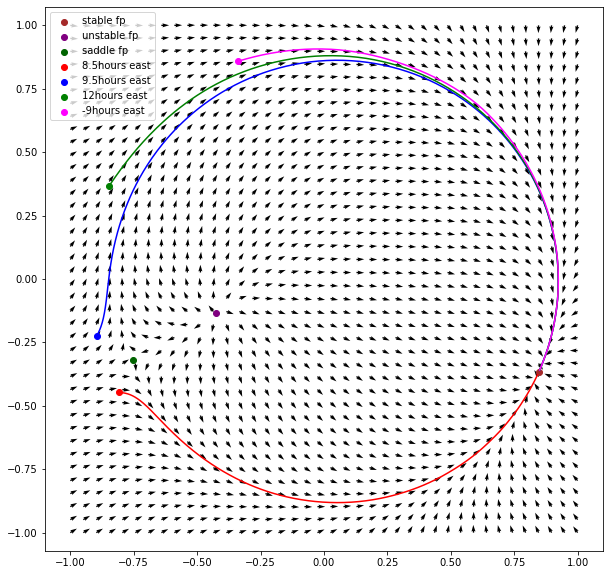

In [62]:
plt.quiver(x,y,u,v)
plt.scatter(solstb[0],solstb[1],label='stable fp',c = 'brown')
plt.scatter(solunstb[0],solunstb[1],label='unstable fp',c='purple')
plt.scatter(solsad[0],solsad[1],label='saddle fp',c='darkgreen')
for index in range(4):
    lags = [8.5,9.5,12,-9]
    colours = ['red','blue','green','magenta']
    lagval = lags[index]
    s = integrate(0,1000,1,lagval)
    ICx,ICy,dummy,dummy1 = getIC(lagval,Delta = 3.8e-3,Omega = 1.4*Delta,K = 10*Delta,F = 3.5*Delta)#Put correct values here
    plt.scatter(ICx,ICy,c=colours[index],label = str(lags[index])+'hours east')
    plt.plot(s.y[0],s.y[1],c=colours[index])
plt.axis('equal')
plt.gcf().set_size_inches(10,10)
plt.legend()
plt.show()